**Without SVI - Type I Data**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/21
218/218 [==============================] - 9s 15ms/step - loss: 0.6143
Epoch 2/21
218/218 [==============================] - 3s 15ms/step - loss: 0.5082
Epoch 3/21
218/218 [==============================] - 3s 14ms/step - loss: 0.4176
Epoch 4/21
218/218 [==============================] - 3s 14ms/step - loss: 0.3619
Epoch 5/21
218/218 [==============================] - 3s 14ms/step - loss: 0.3197
Epoch 6/21
218/218 [==============================] - 3s 14ms/step - loss: 0.2792
Epoch 7/21
218/218 [==============================] - 3s 14ms/step - loss: 0.2645
Epoch 8/21
218/218 [==============================] - 3s 15ms/step - loss: 0.2209
Epoch 9/21
218/218 [==============================] - 3s 15ms/step - loss: 0.2027
Epoch 10/21
218/218 [==============================] - 3s 14ms/step - loss: 0.1843
Epoch 11/21
218/218 [====================

<ipython-input-16-cc108d6853ef>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_test['final_open_pred'] = y_final_pred


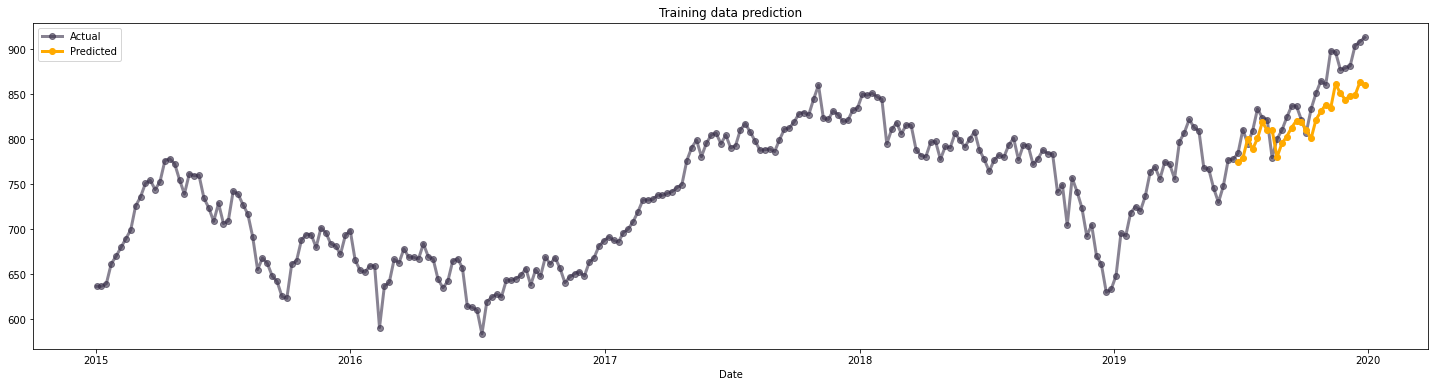

RMSE LSTM: 52.53105349884759
MAE LSTM: 26.401692708333332


In [ ]:
# Importing Modules
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data
import matplotlib.pyplot as plt
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, utils, backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Importing SVI Data & Renaming
aex = pd.read_csv(r"/content/drive/MyDrive/AEX_5years_new.csv")
aex = aex.rename(columns={'AEX: (Wereldwijd)': 'AEX SVI'})
amx = pd.read_csv(r"/content/drive/MyDrive/AMX_5years_new.csv")
amx = amx.rename(columns={'AMX Index: (Wereldwijd)': 'AMX SVI'})
dfaex = pd.DataFrame(aex)
dfamx = pd.DataFrame(amx)

# Renaming Columns 
dfaex = dfaex.rename(columns={'Week': 'Date'})
dfaex['Date'] = pd.to_datetime(dfaex['Date'])
dfaex = dfaex.set_index('Date')

dfamx = dfamx.rename(columns={'Week': 'Date'})
dfamx['Date'] = pd.to_datetime(dfamx['Date'])
dfamx = dfamx.set_index('Date')

# Pulling Yahoo Finance Data
# Defining tickers & dates
ticker_aex = ['^AEX']
ticker_amx = ['^AMX']
start_date = '2015-01-01'
end_date = '2019-12-28'

# Downloading & transforming data to weekly data machting SVI
yfaex = yf.download(ticker_aex, start_date, end_date)
yfaex = yfaex.asfreq('W-FRI', method='pad') 
yfaex = pd.DataFrame(yfaex)

yfamx = yf.download(ticker_amx, start_date, end_date)
yfamx = yfamx.asfreq('W-FRI', method='pad') 
yfamx = pd.DataFrame(yfamx)

# Merging Datasets
dfaex = pd.merge(dfaex, yfaex, left_index=True, right_index=True, how='outer')
df = pd.merge(dfamx, yfamx, left_index=True, right_index=True, how='outer')

# Selecting Columns Type II
columns = ['Open']
df2 = df[columns]

# Determining train and test sizes
size = int(len(df2)*0.9)
df2_train, df2_test = df2[0:size], df2[size:len(df2)]

# Scale data
sc = StandardScaler()
df2_train_scaled = sc.fit_transform(df2_train)
sc2 = StandardScaler()
df2_train_scaled_y = sc2.fit_transform(df2_train[['Open']])

# Constructing X_train & y_train
hops = 16
no_records = 234
no_cols = 1
X_train = []
y_train = []

for i in range (16,234):
  X_train.append(df2_train_scaled[i-16:i])
  y_train.append(df2_train_scaled_y[i][0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape
X_train_shape = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Building LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape = (16, 1)))
model.add(Dropout(0.35))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=21)

# Constructing Dataframe
df1_train_last8 = df2_train.iloc[-16:]
df1_test_full = df2_test
full_df = pd.concat((df1_train_last8,df1_test_full), axis=0)
full_df = sc.transform(full_df)

# Constructing X_train_shape
hops = 16
no_records = 43
no_cols = 1
X_train_shape_pred = []

for i in range (16,43):
  X_train_shape_pred.append(full_df[i-16:i])
X_train_shape_pred = np.array(X_train_shape_pred)

# Prediction
ytest = model.predict(X_train_shape_pred)
y_final_pred = sc2.inverse_transform(ytest)

# Final Dataframe
final_open_pred = pd.DataFrame(y_final_pred)
final_open_pred.columns = ['final_open_pred']
df2_test['final_open_pred'] = y_final_pred

# Plotting
plt.figure(figsize=(25,6))
plt.plot(df['Open'], color = '#39304A', marker = 'o', linewidth=3.0, alpha = 0.6)
plt.plot(df2_test['final_open_pred'], color = '#FFAA00', marker = 'o', linewidth=3.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Date')
plt.title("Training data prediction")
plt.show()

# Calculating errors
rmse = np.sqrt(np.mean(((y_final_pred - df2_test['Open'].values) ** 2)))
print(f'RMSE LSTM: {rmse}')
error = mae(df2_test['Open'].values, y_final_pred)
print(f'MAE LSTM: {error}')


**With SVI - Type II Data**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/21
218/218 [==============================] - 8s 15ms/step - loss: 0.2324
Epoch 2/21
218/218 [==============================] - 3s 15ms/step - loss: 0.1552
Epoch 3/21
218/218 [==============================] - 3s 15ms/step - loss: 0.1332
Epoch 4/21
218/218 [==============================] - 3s 15ms/step - loss: 0.1443
Epoch 5/21
218/218 [==============================] - 3s 14ms/step - loss: 0.1102
Epoch 6/21
218/218 [==============================] - 3s 14ms/step - loss: 0.1106
Epoch 7/21
218/218 [==============================] - 3s 15ms/step - loss: 0.1052
Epoch 8/21
218/218 [==============================] - 3s 14ms/step - loss: 0.0880
Epoch 9/21
218/218 [==============================] - 3s 15ms/step - loss: 0.1057
Epoch 10/21
218/218 [==============================] - 3s 14ms/step - loss: 0.1033
Epoch 11/21
218/218 [====================

<ipython-input-18-af0b8f5dd7c8>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_test['final_open_pred'] = y_final_pred


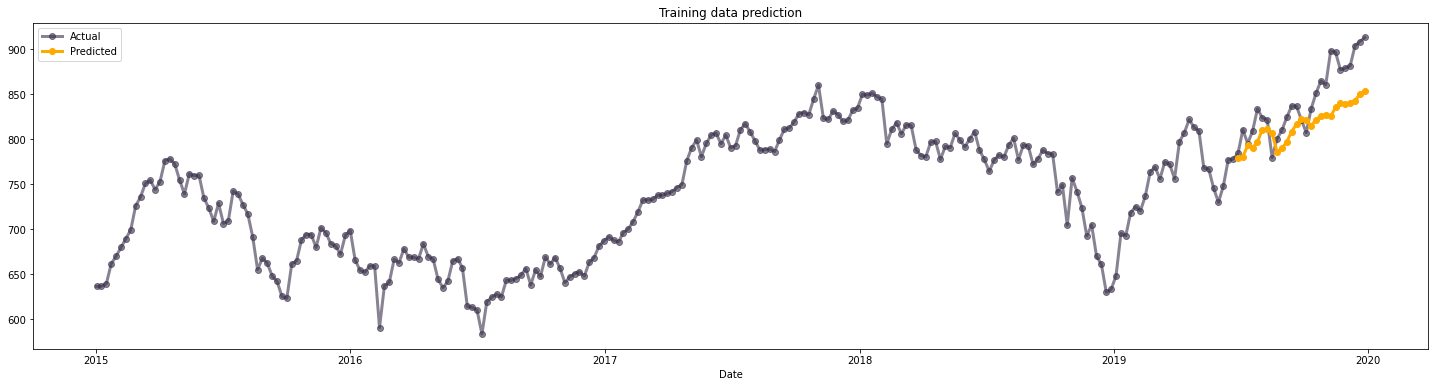

RMSE LSTM: 52.31841280404714
MAE LSTM: 30.37898310908565


In [ ]:
# Importing Modules
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data
import matplotlib.pyplot as plt
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, utils, backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Importing SVI Data & Renaming
aex = pd.read_csv(r"/content/drive/MyDrive/AEX_5years_new.csv")
aex = aex.rename(columns={'AEX: (Wereldwijd)': 'AEX SVI'})
amx = pd.read_csv(r"/content/drive/MyDrive/AMX_5years_new.csv")
amx = amx.rename(columns={'AMX Index: (Wereldwijd)': 'AMX SVI'})
dfaex = pd.DataFrame(aex)
dfamx = pd.DataFrame(amx)

# Renaming Columns 
dfaex = dfaex.rename(columns={'Week': 'Date'})
dfaex['Date'] = pd.to_datetime(dfaex['Date'])
dfaex = dfaex.set_index('Date')

dfamx = dfamx.rename(columns={'Week': 'Date'})
dfamx['Date'] = pd.to_datetime(dfamx['Date'])
dfamx = dfamx.set_index('Date')

# Pulling Yahoo Finance Data
# Defining tickers & dates
ticker_aex = ['^AEX']
ticker_amx = ['^AMX']
start_date = '2015-01-01'
end_date = '2019-12-28'

# Downloading & transforming data to weekly data machting SVI
yfaex = yf.download(ticker_aex, start_date, end_date)
yfaex = yfaex.asfreq('W-FRI', method='pad') 
yfaex = pd.DataFrame(yfaex)

yfamx = yf.download(ticker_amx, start_date, end_date)
yfamx = yfamx.asfreq('W-FRI', method='pad') 
yfamx = pd.DataFrame(yfamx)

# Merging Datasets
dfaex = pd.merge(dfaex, yfaex, left_index=True, right_index=True, how='outer')
df = pd.merge(dfamx, yfamx, left_index=True, right_index=True, how='outer')

# Selecting Columns Type II
columns = ['Open', 'AMX SVI']
df2 = df[columns]

# Determining train and test sizes
size = int(len(df2)*0.9)
df2_train, df2_test = df2[0:size], df2[size:len(df2)]

# Scale data
sc = StandardScaler()
df2_train_scaled = sc.fit_transform(df2_train)
sc2 = StandardScaler()
df2_train_scaled_y = sc2.fit_transform(df2_train[['Open']])

# Constructing X_train & y_train
hops = 16
no_records = 234
no_cols = 2
X_train = []
y_train = []

for i in range (16,234):
  X_train.append(df2_train_scaled[i-16:i])
  y_train.append(df2_train_scaled_y[i][0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape
X_train_shape = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Building LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape = (16, 2)))
model.add(Dropout(0.35))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(5, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=21)

# Constructing Dataframe
df1_train_last8 = df2_train.iloc[-16:]
df1_test_full = df2_test
full_df = pd.concat((df1_train_last8,df1_test_full), axis=0)
full_df = sc.transform(full_df)

# Constructing X_train_shape
hops = 16
no_records = 43
no_cols = 2
X_train_shape_pred = []

for i in range (16,43):
  X_train_shape_pred.append(full_df[i-16:i])
X_train_shape_pred = np.array(X_train_shape_pred)

# Prediction
ytest = model.predict(X_train_shape_pred)
y_final_pred = sc2.inverse_transform(ytest)

# Final Dataframe
final_open_pred = pd.DataFrame(y_final_pred)
final_open_pred.columns = ['final_open_pred']
df2_test['final_open_pred'] = y_final_pred

# Plotting
plt.figure(figsize=(25,6))
plt.plot(df['Open'], color = '#39304A', marker = 'o', linewidth=3.0, alpha = 0.6)
plt.plot(df2_test['final_open_pred'], color = '#FFAA00', marker = 'o', linewidth=3.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Date')
plt.title("Training data prediction")
plt.show()

# Calculating errors
rmse = np.sqrt(np.mean(((y_final_pred - df2_test['Open'].values) ** 2)))
print(f'RMSE LSTM: {rmse}')
error = mae(df2_test['Open'].values, y_final_pred)
print(f'MAE LSTM: {error}')
